# Mediapip Posture Correction
### with the roboflow dataset

MediaPipe Model Maker is a tool for customizing existing machine learning (ML) models to work with your data and applications. You can use this tool as a faster alternative to building and training a new ML model.

MediaPipe is an open-source framework for building pipelines to perform computer vision inference over arbitrary sensory data such as video or audio. Using MediaPipe, such a perception pipeline can be built as a graph of modular components. MediaPipe is currently in alpha at v0.

### Table of Contents

1. [Install Packages](#Install-Packages)
1. [Detections with Images and Webcam](#Detections-with-Images-and-Webcam)
1. [Save Landmarks & Export to CSV (Coords)](#Save-Landmarks-&-Export-to-CSV-(Coords))
1. [Model Training and Testing](#Model-Training-and-Testing)
    * [Classification Models](#Classification-Models)
        * [Review and save the models](#Review-and-save-the-models)
        * [Posture Correction Testing](#Posture-Correction-Testing-with-Trained-Model)
    * [NN Model](#NN-Model)
        * [Review NN model](#Review-NN-model)
        * [Posture Correction Testing](#Webcam-testing-with-the-trained-NN-model)
        * [Save Model](#Save-Model)
        
1. [Testing: Resolve Imbalanced Dataset Issue](#Testing:-Resolve-Imbalanced-Dataset-Issue)

## Install Packages

In [45]:
!pip install mediapipe opencv-python pandas scikit-learn chime --quiet

In [27]:
import warnings
warnings.filterwarnings("ignore")

import mediapipe as mp 
import cv2
import time
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score # Accuracy metrics 
import pickle 

import chime

In [2]:
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_holistic = mp.solutions.holistic # Mediapipe Solutions

## Detections with Images and Webcam

### Images

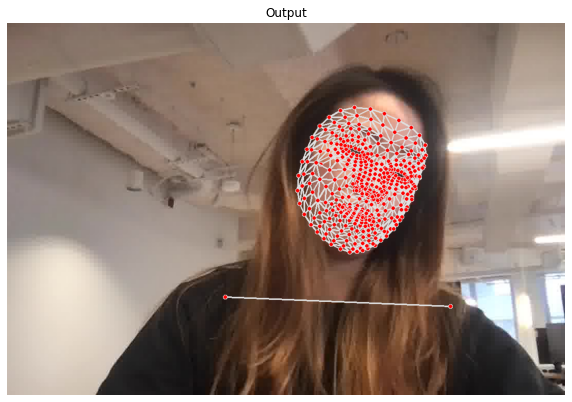

In [78]:
# Create a copy of the sample image to draw landmarks on.
sample_img  = cv2.imread('bad1.jpg')
img_copy = sample_img.copy()

# Check if any landmarks are found.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    results = holistic.process(img_copy)

    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, 
                              landmark_list=results.pose_landmarks, # points
                              connections=mp_holistic.POSE_CONNECTIONS) # corrections
       
    mp_drawing.draw_landmarks(image=img_copy, 
                              landmark_list = results.face_landmarks, 
                              connections= mp_holistic.FACEMESH_TESSELATION)
        
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

In [79]:
tuple(np.multiply(
                        np.array(
                            (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                             results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                    , [480,240]).astype(int))

(348, 105)

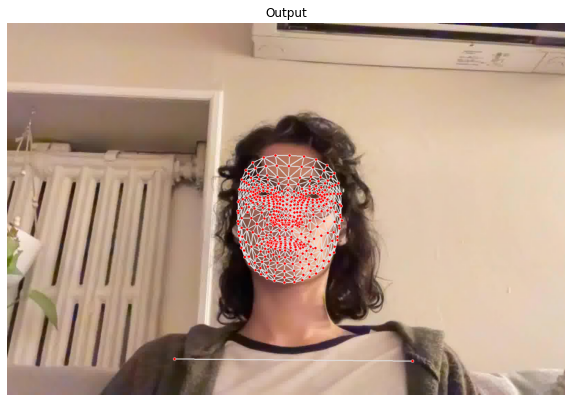

In [80]:
# Create a copy of the sample image to draw landmarks on.
sample_img  = cv2.imread('good2.jpg')
img_copy = sample_img.copy()

# Check if any landmarks are found.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    results = holistic.process(img_copy)

    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, 
                              landmark_list=results.pose_landmarks, # points
                              connections=mp_holistic.POSE_CONNECTIONS) # corrections
       
    mp_drawing.draw_landmarks(image=img_copy, 
                              landmark_list = results.face_landmarks, 
                              connections= mp_holistic.FACEMESH_TESSELATION)
        
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

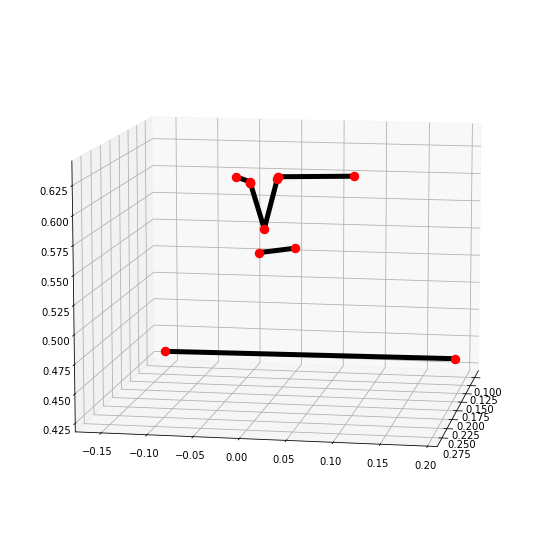

In [91]:

# Plot Pose landmarks in 3D.
mp_drawing.plot_landmarks(results.pose_world_landmarks, 
                          mp_holistic.POSE_CONNECTIONS)

In [8]:
tuple(np.multiply(np.array(
                            (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                             results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                    , [480,240]).astype(int))

(288, 127)

### Webcam

In [12]:
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                 )
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


KeyboardInterrupt: 

In [13]:
results.face_landmarks.landmark[0]

x: 0.640782356262207
y: 0.7596138119697571
z: -0.025928692892193794

**Back to [Top](#Table-of-Contents)**

## Save Landmarks & Export to CSV (Coords)

In [6]:
num_coords = len(results.pose_landmarks.landmark)+len(results.face_landmarks.landmark)
num_coords

501

In [7]:
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [8]:
pd.DataFrame(landmarks).to_csv("coords_3.csv")

In [18]:
!pwd

/Users/lindseybang/Desktop/github/W251/W251-Final-Project-Mediapipe


In [9]:
with open('coords_3.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [51]:
class_name = "Sit Up Straight"
# class_name = "Good"

# rootdir = '/Users/lindseybang/Downloads/posture_correction_v4-1/train/looks good'
# rootdir = '/Users/lindseybang/Downloads/posture_correction_v4-1/test/looks good'
# rootdir = '/Users/lindseybang/Downloads/posture_correction_v4-1/valid/looks good'

# rootdir = '/Users/lindseybang/Downloads/posture_correction_v4-1/train/sit up straight'
# rootdir = '/Users/lindseybang/Downloads/posture_correction_v4-1/test/sit up straight'
rootdir = '/Users/lindseybang/Downloads/posture_correction_v4-1/valid/sit up straight'


In [52]:
# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:
#         fpath = os.path.join(subdir, file)
#         print(fpath)

In [53]:
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            fpath = os.path.join(subdir, file)

            # Recolor Feed
            # image = cv2.cvtColor(fpath, cv2.COLOR_BGR2RGB)
            image = cv2.imread(fpath, cv2.IMREAD_COLOR)
            image.flags.writeable = False        

            # Make Detections
            results = holistic.process(image)
            # print(results.face_landmarks)

            # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks

            # Recolor image back to BGR for rendering
            image.flags.writeable = True   
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # face landmarks
            mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                                     mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                                     mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                     )

            # pose landmarks
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )
            # Export coordinates
            try:
                # Extract Pose landmarks
                pose = results.pose_landmarks.landmark
                pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())

                # Extract Face landmarks
                face = results.face_landmarks.landmark
                face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())

                # Concate rows
                row = pose_row+face_row

                # Append class name 
                row.insert(0, class_name)

                # Export to CSV
                with open('coords_3.csv', mode='a', newline='') as f:
                    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerow(row) 

            except:
                pass

In [256]:
# pose = results.pose_landmarks.landmark
# list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
 

**Back to [Top](#Table-of-Contents)**

## Model Training and Testing

#### Data Processing

In [50]:
# !pwd

In [28]:
df = pd.read_csv('coords_3.csv')

In [29]:
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z499,v499,x500,y500,z500,v500,x501,y501,z501,v501
0,Good,0.537393,0.539602,-1.471861,0.999845,0.561754,0.483659,-1.382684,0.999714,0.577142,...,0.013152,0.0,0.573103,0.497040,0.038865,0.0,0.578001,0.494075,0.040125,0.0
1,Good,0.509928,0.432858,-1.150008,0.999652,0.534388,0.366596,-1.072026,0.999325,0.550994,...,0.002331,0.0,0.592100,0.343983,0.025223,0.0,0.597142,0.335447,0.026443,0.0
2,Good,0.494811,0.292907,-0.688909,0.999661,0.512799,0.249482,-0.644204,0.999347,0.526903,...,-0.002133,0.0,0.540415,0.275314,0.007793,0.0,0.543725,0.270260,0.007973,0.0
3,Good,0.630600,0.429227,-0.781505,0.999660,0.648137,0.368784,-0.734205,0.999331,0.667481,...,0.002782,0.0,0.580056,0.357574,0.024740,0.0,0.584648,0.350142,0.025837,0.0
4,Good,0.544019,0.593949,-1.162976,0.999483,0.572813,0.525275,-1.113924,0.999012,0.590097,...,-0.011962,0.0,0.631761,0.541886,0.006789,0.0,0.637083,0.537069,0.006730,0.0


In [30]:
df.tail()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z499,v499,x500,y500,z500,v500,x501,y501,z501,v501
4862,Sit Up Straight,0.562184,0.379126,-0.982769,0.997982,0.580522,0.333598,-0.917959,0.996865,0.595705,...,-0.002145,0.0,0.587438,0.368901,0.016831,0.0,0.592201,0.361945,0.017478,0.0
4863,Sit Up Straight,0.272359,0.308540,-1.028379,0.998090,0.313944,0.241066,-1.024402,0.997039,0.338825,...,-0.009351,0.0,0.328635,0.132131,-0.037166,0.0,0.336371,0.118703,-0.040492,0.0
4864,Sit Up Straight,0.418144,0.297889,-1.194281,0.998228,0.449877,0.203363,-1.182303,0.997217,0.469516,...,-0.016931,0.0,0.565850,0.172496,-0.007729,0.0,0.575301,0.156644,-0.008412,0.0
4865,Sit Up Straight,0.749652,0.281387,-1.067757,0.992377,0.748099,0.184355,-1.015236,0.989821,0.753715,...,0.019144,0.0,0.821771,0.124784,0.073735,0.0,0.822423,0.119142,0.077718,0.0
4866,Sit Up Straight,0.701035,0.231171,-0.859105,0.992779,0.713512,0.157880,-0.789535,0.990385,0.724102,...,0.013292,0.0,0.757050,0.167109,0.060321,0.0,0.762827,0.159940,0.063558,0.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4867 entries, 0 to 4866
Columns: 2005 entries, class to v501
dtypes: float64(2004), object(1)
memory usage: 74.5+ MB


In [32]:
df.groupby(['class']).count().iloc[:,0]

class
Good               1299
Sit Up Straight    3568
Name: x1, dtype: int64

In [33]:
df = df.fillna(0) 

In [34]:
X = df.drop('class', axis=1) #.to_numpy() # features
y = df['class'] #.to_numpy() # target value

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

### Classification Models

In [12]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier())
    # 'xg':make_pipeline(StandardScaler(), XGBClassifier(objective='binary:logistic'))
}

In [65]:
fit_models = {}
for algo, pipeline in pipelines.items():
    start = time.time()
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model
    end = time.time()
    print(f'{pipeline} Time (in mins): {(end - start)/60.0:.5f}\n')

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())]) Time (in mins): 0.01128

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgeclassifier', RidgeClassifier())]) Time (in mins): 0.00924

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())]) Time (in mins): 0.11294

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())]) Time (in mins): 2.46144



In [66]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())])}

In [67]:
# fit_models['rc'].predict(X_test)

### Review and save the models

In [67]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

lr 0.9168377823408624
rc 0.9281314168377823
rf 0.9260780287474333
gb 0.9589322381930184


In [17]:
# np.arrays (X and Y coming from the NN input values)
# comment  the model below since other models saw higher accuracy
# xgb = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# # fit model
# xgb.fit(X_train, y_train)
# # make predictions
# preds = bst.predict(X_test)
# print('xgb ', accuracy_score(y_test, preds))

In [95]:
# fit_models['lr'].predict(X_test)

In [68]:
with open('pose_detection_3.pkl', 'wb') as f:
    # pickle.dump(fit_models['gb'], f)
    pickle.dump(fit_models['gb'], f)

### Posture Correction Testing with Trained Model

In [69]:
with open('pose_detection_3.pkl', 'rb') as f:
    model = pickle.load(f)

In [70]:
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [71]:
cap = cv2.VideoCapture(0)
fps = int(cap.get(cv2.CAP_PROP_FPS))
good_frames = 0
bad_frames = 0 
chime.theme("mario")

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        try:
            # Extract Pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            # Extract Face landmarks
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
            
            # Concate rows
            row = pose_row+face_row

            # Make Detections
            X = pd.DataFrame([row])
            pose_detection_class = model.predict(X)[0]
            pose_detection_prob = model.predict_proba(X)[0]
            print(pose_detection_class, pose_detection_prob)
            
            
            if pose_detection_class == 'Good':
                good_frames += 1
                bad_frames = 0
            else:
                good_frames = 0
                bad_frames += 1
                
                
            good_time = (1. / fps) * good_frames
            bad_time = (1. / fps) * bad_frames
            
            # To display the text, grab ear coords
            coords = tuple(np.multiply(
                            np.array(
                                (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                 results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                        , [480,240]).astype(int))
            
            # cv2.rectangle(image, 
            #               (coords[0], coords[1]+5), 
            #               (coords[0]+len(pose_detection_class)*20, coords[1]-30), 
            #               (245, 117, 16), -1)
            
            if pose_detection_class == 'Good':
                cv2.rectangle(image, 
                              (coords[0], coords[1]+5), 
                              (coords[0]+len(pose_detection_class)*20, coords[1]-30), 
                              (0, 128, 0), -1)
            else:
                cv2.rectangle(image, 
                              (coords[0], coords[1]+5), 
                              (coords[0]+len(pose_detection_class)*16, coords[1]-30), 
                              (105,105,105), -1)
            
            
            cv2.putText(image, pose_detection_class, coords, 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Get status box
            # cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            # Get status box
            if pose_detection_class == 'Good':
                cv2.rectangle(image, (0,0), (250, 60), (0, 128, 0), -1)
            else:
                cv2.rectangle(image, (0,0), (250, 60), (105,105,105), -1)
            
            # Display Class
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, pose_detection_class.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Display Probability
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(pose_detection_prob[np.argmax(pose_detection_prob)],2))
                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        except:
            pass
        
        if bad_time > 60:
                chime.warning()
                bad_frames = 0
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

Sit Up Straight [0.07347924 0.92652076]
Sit Up Straight [0.04523004 0.95476996]
Sit Up Straight [0.06365549 0.93634451]
Sit Up Straight [0.06365549 0.93634451]
Sit Up Straight [0.07430852 0.92569148]
Sit Up Straight [0.07430852 0.92569148]
Sit Up Straight [0.08772113 0.91227887]
Sit Up Straight [0.09444962 0.90555038]
Sit Up Straight [0.08594417 0.91405583]
Sit Up Straight [0.07680874 0.92319126]
Sit Up Straight [0.07308556 0.92691444]
Sit Up Straight [0.07308556 0.92691444]
Sit Up Straight [0.09971 0.90029]
Sit Up Straight [0.07646646 0.92353354]
Sit Up Straight [0.07046312 0.92953688]
Sit Up Straight [0.07046312 0.92953688]
Sit Up Straight [0.08701891 0.91298109]
Sit Up Straight [0.32115659 0.67884341]
Good [0.70048049 0.29951951]
Good [0.69341761 0.30658239]
Good [0.56042433 0.43957567]
Good [0.76461641 0.23538359]
Good [0.78429576 0.21570424]
Good [0.84992295 0.15007705]
Good [0.86925295 0.13074705]
Good [0.83370899 0.16629101]
Good [0.85526481 0.14473519]
Good [0.87262795 0.127372

KeyboardInterrupt: 

**Back to [Top](#Table-of-Contents)**

## NN Model

In [36]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import shutil
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
from tensorflow.keras.applications import VGG19
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [37]:
df_1 = pd.read_csv('coords_3.csv')
df_1['class'] = df_1['class'].replace('Good', 0).replace('Sit Up Straight',1)

In [38]:
train, test = train_test_split(df_1, test_size=0.15, random_state=1234)
train, val = train_test_split(train, test_size=0.1, random_state=1234)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3722 train examples
414 validation examples
731 test examples


In [39]:
# X_train = train.drop('class', axis=1) #.to_numpy() # features
# y_train = train['class'] #.to_numpy() # target value

In [40]:
X_train = train.drop('class', axis=1) #.to_numpy() # features
y_train = train['class'] #.to_numpy() # target value

X_test = test.drop('class', axis=1) #.to_numpy() # features
y_test = test['class'] #.to_numpy() # target value

X_val = val.drop('class', axis=1) #.to_numpy() # features
y_val = val['class'] #.to_numpy() # target value

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


In [41]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)


X_val = np.array(X_val)
y_val = np.array(y_val)

In [42]:
X_train[0].shape

(2004,)

In [43]:
X_train[0]

array([ 0.49855059,  0.33514217, -0.56804878, ...,  0.28436029,
        0.03728272,  0.        ])

In [44]:
def create_model(dropout=0.3, learning_rate=0.0001):
        
    keypoints = tf.keras.layers.Input(shape=(2004,), dtype=np.float32)
    
    flattened = tf.keras.layers.Flatten()(keypoints)
    hidden_1 = tf.keras.layers.Dense(512, activation="relu", name="hidden_1")(flattened)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(256, activation="relu", name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    hidden_3 = tf.keras.layers.Dense(128, activation="relu", name="hidden_3")(hidden_2)
    hidden_3 = tf.keras.layers.Dropout(dropout)(hidden_3)
    
    classification = tf.keras.layers.Dense(2, activation="softmax", name="classification_layer")(hidden_3)
    # sigmoid
    classification_model = tf.keras.Model(inputs=[keypoints], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics=["accuracy"],
                                 run_eagerly=True)
    
    return classification_model

In [45]:
model = create_model()

In [46]:
history = model.fit(X_train,
                    y_train, 
                    validation_data=[X_test, y_test], 
                    batch_size = 16, 
                    epochs = 100)

Epoch 1/100
233/233 [==============================] - 10s 41ms/step - loss: 0.5944 - accuracy: 0.7243 - val_loss: 0.5430 - val_accuracy: 0.7456
Epoch 2/100
233/233 [==============================] - 9s 40ms/step - loss: 0.5679 - accuracy: 0.7311 - val_loss: 0.5259 - val_accuracy: 0.7456
Epoch 3/100
233/233 [==============================] - 10s 42ms/step - loss: 0.5360 - accuracy: 0.7300 - val_loss: 0.5026 - val_accuracy: 0.7456
Epoch 4/100
233/233 [==============================] - 12s 52ms/step - loss: 0.5133 - accuracy: 0.7332 - val_loss: 0.5053 - val_accuracy: 0.7483
Epoch 5/100
233/233 [==============================] - 12s 52ms/step - loss: 0.4963 - accuracy: 0.7389 - val_loss: 0.4701 - val_accuracy: 0.7456
Epoch 6/100
233/233 [==============================] - 11s 46ms/step - loss: 0.4813 - accuracy: 0.7335 - val_loss: 0.4943 - val_accuracy: 0.7606
Epoch 7/100
233/233 [==============================] - 11s 46ms/step - loss: 0.4705 - accuracy: 0.7477 - val_loss: 0.4616 - val_acc

### Review NN model

(0.0, 1.0)

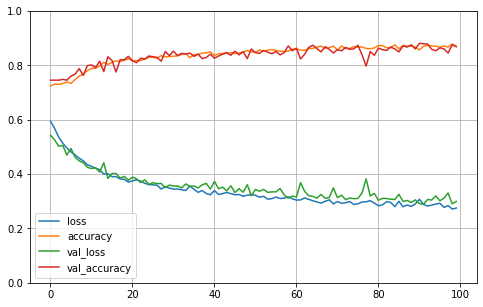

In [47]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

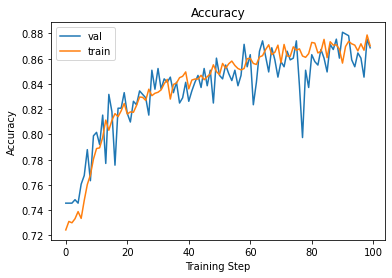

In [48]:
# Visualize accuracy

acc = history.history['val_accuracy']
train_acc = history.history['accuracy']
plt.plot(acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()


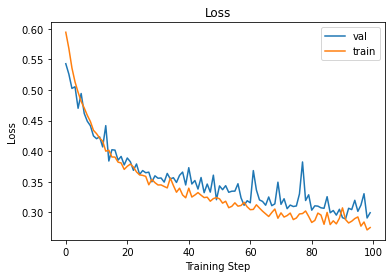

In [49]:
# Visualize accuracy

acc = history.history['val_loss']
train_acc = history.history['loss']
plt.plot(acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


In [50]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       186
           1       0.92      0.90      0.91       545

    accuracy                           0.87       731
   macro avg       0.83      0.83      0.83       731
weighted avg       0.87      0.87      0.87       731



**Back to [Top](#Table-of-Contents)**

### Webcam testing with the trained NN model

In [50]:
cap = cv2.VideoCapture(0)
fps = int(cap.get(cv2.CAP_PROP_FPS))
good_frames = 0
bad_frames = 0 
chime.theme("mario")

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Export coordinates
        try:
            # Extract Pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            # Extract Face landmarks
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
            
            # Concate rows
            row = pose_row+face_row


            # Make Detections
            
            # X = np.array(pd.DataFrame([row]))
            X = np.array([row])
            
            pose_detection_value = model.predict(X)[0][0]
            comp_pose_detection_value = model.predict(X)[0][1]
        
            if pose_detection_value >= comp_pose_detection_value:
                pose_detection_class = 'Good'
                pose_detection_prob = pose_detection_value
            else:
                pose_detection_class = 'Sit Up Straight'
                pose_detection_prob = comp_pose_detection_value
                    
            if pose_detection_class == 'Good':
                good_frames += 1
                bad_frames = 0
            else:
                good_frames = 0
                bad_frames += 1
                
                
            good_time = (1. / fps) * good_frames
            bad_time = (1. / fps) * bad_frames
            
            
            # To display the text, grab ear coords
            coords = tuple(np.multiply(
                            np.array(
                                (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                 results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                        , [480,240]).astype(int))

            
            if pose_detection_class == 'Good':
                cv2.rectangle(image, 
                              (coords[0], coords[1]+5), 
                              (coords[0]+len(pose_detection_class)*20, coords[1]-30), 
                              (0, 128, 0), -1)
            else:
                cv2.rectangle(image, 
                              (coords[0], coords[1]+5), 
                              (coords[0]+len(pose_detection_class)*16, coords[1]-30), 
                              (105,105,105), -1)
            
            
            cv2.putText(image, pose_detection_class, coords, 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Get status box
            # cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            # Get status box
            if pose_detection_class == 'Good':
                cv2.rectangle(image, (0,0), (250, 60), (0, 128, 0), -1)
            else:
                cv2.rectangle(image, (0,0), (250, 60), (105,105,105), -1)
            
            # Display Class
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(image, pose_detection_class.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Display Probability
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(pose_detection_prob,2))
                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        except:
            pass
        
        if bad_time > 60:
                chime.warning()
                bad_frames = 0
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


KeyboardInterrupt: 

**Back to [Top](#Table-of-Contents)**

### Save Model

In [51]:
current_path = os.getcwd()

In [52]:
model.save(current_path)

2023-04-14 18:00:45.431690: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/lindseybang/Desktop/github/W251/W251-Final-Project-Lindsey/assets


In [ ]:
model = keras.models.load_model(current_path)

**Back to [Top](#Table-of-Contents)**

================================================================================================

## Testing: Resolve Imbalanced Dataset Issue

### SMOTE

Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique for increasing the number of cases in your dataset in a balanced way. The component works by generating new instances from existing minority cases that you supply as input. This implementation of SMOTE does not change the number of majority cases.


In [75]:
# !pwd

In [36]:
train = pd.read_csv('smote/train_dataset.csv')
test = pd.read_csv('smote/test_dataset.csv')
val = pd.read_csv('smote/valid_dataset.csv')

In [37]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3282 train examples
292 validation examples
515 test examples


In [38]:
train.groupby(['class']).count().iloc[:,0]

class
0    1641
1    1641
Name: x1, dtype: int64

In [39]:
test.groupby(['class']).count().iloc[:,0]

class
0    208
1    307
Name: x1, dtype: int64

In [40]:
val.groupby(['class']).count().iloc[:,0]

class
0    107
1    185
Name: x1, dtype: int64

In [41]:
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE(random_state=1234)

# X_train = train.drop('class', axis=1) #.to_numpy() # features
# y_train = train['class'] #.to_numpy() # target value

# X_train, y_train = oversample.fit_resample(X_train, y_train)

In [42]:
train

,x1,y1,z1,v1,x2,y2,z2,v2,x3,y3,...,v499,x500,y500,z500,v500,x501,y501,z501,v501,class
0,0.540002,0.322209,-0.990675,0.999563,0.564268,0.271037,-0.939398,0.999180,0.581350,0.275310,...,0,0.577245,0.249441,0.030507,0,0.582134,0.243088,0.031772,0,1
1,0.534705,0.289675,-1.206272,0.999413,0.549807,0.214778,-1.146174,0.998951,0.564221,0.214354,...,0,0.558994,0.204918,0.014162,0,0.564154,0.194379,0.014916,0,1
2,0.414555,0.369428,-0.958249,0.998490,0.422145,0.295514,-0.919035,0.996986,0.439622,0.289138,...,0,0.409290,0.285482,0.022601,0,0.409604,0.273302,0.023844,0,1
3,0.514969,0.442723,-0.811415,0.999251,0.534677,0.383630,-0.753612,0.998611,0.551521,0.382835,...,0,0.574000,0.402533,0.020996,0,0.578460,0.395093,0.021910,0,0
4,0.502766,0.372675,-0.835694,0.999358,0.526227,0.316107,-0.780894,0.998806,0.545535,0.314845,...,0,0.522014,0.288174,0.006105,0,0.527733,0.280654,0.005891,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3277,0.544606,0.376116,-1.434934,0.999418,0.568653,0.285963,-1.341620,0.999038,0.587546,0.288092,...,0,0.565481,0.344350,0.034568,0,0.570413,0.339625,0.035502,0,0
3278,0.529374,0.393980,-1.473085,0.998624,0.559510,0.336511,-1.375980,0.997946,0.580336,0.337824,...,0,0.572030,0.350109,0.037878,0,0.577396,0.345140,0.039161,0,0
3279,0.531927,0.405143,-1.658973,0.994870,0.561198,0.334295,-1.547345,0.992056,0.582767,0.338182,...,0,0.586947,0.353355,0.046388,0,0.591833,0.349664,0.048124,0,0
3280,0.520414,0.194870,-0.814981,0.999689,0.551893,0.130187,-0.760069,0.999345,0.571748,0.131245,...,0,0.586517,0.092960,0.025714,0,0.592802,0.083372,0.026739,0,0


In [44]:
X_train = train.drop('class', axis=1) #.to_numpy() # features
y_train = train['class'] #.to_numpy() # target value

X_test = test.drop('class', axis=1) #.to_numpy() # features
y_test = test['class'] #.to_numpy() # target value


X_val = val.drop('class', axis=1) #.to_numpy() # features
y_val = val['class'] #.to_numpy() # target value

In [45]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [46]:
def create_model(dropout=0.3, learning_rate=0.001):
        
    keypoints = tf.keras.layers.Input(shape=(2004,), dtype=np.float32)
    
    flattened = tf.keras.layers.Flatten()(keypoints)
    hidden_1 = tf.keras.layers.Dense(512, activation="relu", name="hidden_1")(flattened)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(256, activation="relu", name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    hidden_3 = tf.keras.layers.Dense(128, activation="relu", name="hidden_3")(hidden_2)
    hidden_3 = tf.keras.layers.Dropout(dropout)(hidden_3)
    
    classification = tf.keras.layers.Dense(2, activation="softmax", name="classification_layer")(hidden_3)
    # sigmoid
    classification_model = tf.keras.Model(inputs=[keypoints], outputs=[classification])
    
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 # loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                                 metrics=["accuracy"],
                                 run_eagerly=True)
    
    return classification_mdel

In [47]:
model = create_model()


In [48]:
history = model.fit(X_train,
                    y_train, 
                    validation_data=[X_test, y_test], 
                    batch_size = 16, 
                    epochs = 100)

Epoch 1/100
206/206 [==============================] - 4s 17ms/step - loss: 0.6992 - accuracy: 0.5478 - val_loss: 0.6055 - val_accuracy: 0.6136
Epoch 2/100
206/206 [==============================] - 3s 16ms/step - loss: 0.5929 - accuracy: 0.6718 - val_loss: 0.5624 - val_accuracy: 0.6699
Epoch 3/100
206/206 [==============================] - 3s 16ms/step - loss: 0.5461 - accuracy: 0.7099 - val_loss: 0.4861 - val_accuracy: 0.7359
Epoch 4/100
206/206 [==============================] - 3s 16ms/step - loss: 0.5248 - accuracy: 0.7279 - val_loss: 0.5236 - val_accuracy: 0.7301
Epoch 5/100
206/206 [==============================] - 3s 16ms/step - loss: 0.4838 - accuracy: 0.7559 - val_loss: 0.4407 - val_accuracy: 0.7825
Epoch 6/100
206/206 [==============================] - 4s 17ms/step - loss: 0.4504 - accuracy: 0.7742 - val_loss: 0.4281 - val_accuracy: 0.7864
Epoch 7/100
206/206 [==============================] - 4s 19ms/step - loss: 0.4784 - accuracy: 0.7617 - val_loss: 0.4220 - val_accuracy:

**Back to [Top](#Table-of-Contents)**

(0.0, 1.0)

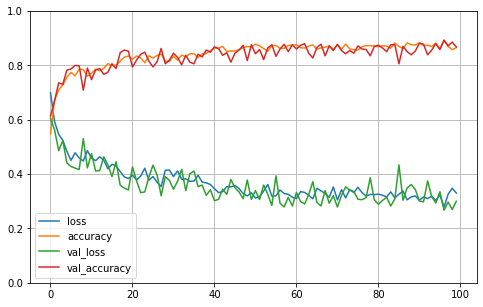

In [49]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

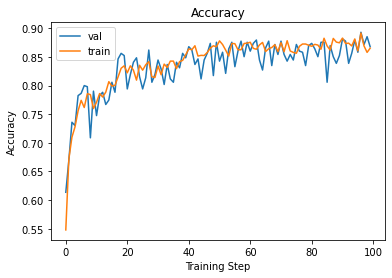

In [50]:
# Visualize accuracy

acc = history.history['val_accuracy']
train_acc = history.history['accuracy']
plt.plot(acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

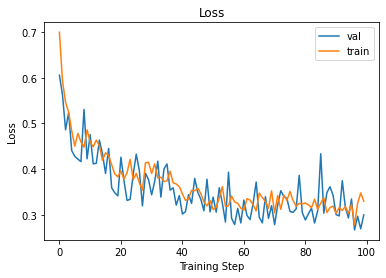

In [51]:
# Visualize accuracy

acc = history.history['val_loss']
train_acc = history.history['loss']
plt.plot(acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [52]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       208
           1       0.94      0.83      0.88       307

    accuracy                           0.87       515
   macro avg       0.86      0.88      0.87       515
weighted avg       0.88      0.87      0.87       515



In [53]:
cap = cv2.VideoCapture(0)
fps = int(cap.get(cv2.CAP_PROP_FPS))
good_frames = 0
bad_frames = 0 
chime.theme("mario")

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False        
        
        # Make Detections
        results = holistic.process(image)
        # print(results.face_landmarks)
        
        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Export coordinates
        try:
            # Extract Pose landmarks
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())
            
            # Extract Face landmarks
            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())
            
            # Concate rows
            row = pose_row+face_row


            # Make Detections
            
            # X = np.array(pd.DataFrame([row]))
            X = np.array([row])
            
            pose_detection_value = model.predict(X)[0][0]
            comp_pose_detection_value = model.predict(X)[0][1]
        
            if pose_detection_value >= comp_pose_detection_value:
                pose_detection_class = 'Good'
                pose_detection_prob = pose_detection_value
            else:
                pose_detection_class = 'Sit Up Straight'
                pose_detection_prob = comp_pose_detection_value
                    
            if pose_detection_class == 'Good':
                good_frames += 1
                bad_frames = 0
            else:
                good_frames = 0
                bad_frames += 1
                
                
            good_time = (1. / fps) * good_frames
            bad_time = (1. / fps) * bad_frames
            
            
            # To display the text, grab ear coords
            coords = tuple(np.multiply(
                            np.array(
                                (results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x, 
                                 results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y))
                        , [480,240]).astype(int))

            
            if pose_detection_class == 'Good':
                cv2.rectangle(image, 
                              (coords[0], coords[1]+5), 
                              (coords[0]+len(pose_detection_class)*20, coords[1]-30), 
                              (0, 128, 0), -1)
            else:
                cv2.rectangle(image, 
                              (coords[0], coords[1]+5), 
                              (coords[0]+len(pose_detection_class)*16, coords[1]-30), 
                              (105,105,105), -1)
            
            
            cv2.putText(image, pose_detection_class, coords, 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Get status box
            # cv2.rectangle(image, (0,0), (250, 60), (245, 117, 16), -1)
            # Get status box
            if pose_detection_class == 'Good':
                cv2.rectangle(image, (0,0), (250, 60), (0, 128, 0), -1)
            else:
                cv2.rectangle(image, (0,0), (250, 60), (105,105,105), -1)
            
            # Display Class
            cv2.putText(image, 'CLASS'
                        , (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(image, pose_detection_class.split(' ')[0]
                        , (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Display Probability
            cv2.putText(image, 'PROB'
                        , (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(pose_detection_prob,2))
                        , (10,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        except:
            pass
        
        if bad_time > 60:
                chime.warning()
                bad_frames = 0
                        
        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


KeyboardInterrupt: 

**Back to [Top](#Table-of-Contents)**

## Create requirements.txt

In [72]:
!pip install pipreqs

In [73]:
!pipreqs /Users/lindseybang/Desktop/github/W251/W251-Final-Project-Lindsey

INFO: Successfully saved requirements file in /Users/lindseybang/Desktop/github/W251/W251-Final-Project-Lindsey/requirements.txt


**Back to [Top](#Table-of-Contents)**